# Proyecto final de imágenes
## EL5206-2 Laboratorio de inteligencia computacional y robótica
### **Integrantes:**
### Benjamín Castro
### Melanie Peña
### **Auxiliar:**
### Jorge Zambrano
### **Profesor:**
### Carlos Navarro



#### Imports de las librerías y archivos

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage
import skimage.feature as feature
import tensorflow
import pandas as pd
from pathlib import Path

# Se usa el modelo pre-entrenado VGG-16
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image

# Arregla el error de la función imshow (en caso que sea necesaria)
from google.colab.patches import cv2_imshow

In [2]:
# JPG1
if not Path("jpg1.tar.gz").is_file():
  !wget "ftp://ftp.inrialpes.fr/pub/lear/douze/data/jpg1.tar.gz"

--2022-11-28 15:23:34--  ftp://ftp.inrialpes.fr/pub/lear/douze/data/jpg1.tar.gz
           => ‘jpg1.tar.gz’
Resolving ftp.inrialpes.fr (ftp.inrialpes.fr)... 194.199.18.221
Connecting to ftp.inrialpes.fr (ftp.inrialpes.fr)|194.199.18.221|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/lear/douze/data ... done.
==> SIZE jpg1.tar.gz ... 1141827194
==> PASV ... done.    ==> RETR jpg1.tar.gz ... done.
Length: 1141827194 (1.1G) (unauthoritative)

jpg1.tar.gz         100%[===================>]   1.06G  4.62MB/s    in 2m 38s  

2022-11-28 15:26:14 (6.89 MB/s) - ‘jpg1.tar.gz’ saved [1141827194]



In [3]:
# JPG2
if not Path("jpg2.tar.gz").is_file():
  !wget "ftp://ftp.inrialpes.fr/pub/lear/douze/data/jpg2.tar.gz"

--2022-11-28 15:26:15--  ftp://ftp.inrialpes.fr/pub/lear/douze/data/jpg2.tar.gz
           => ‘jpg2.tar.gz’
Resolving ftp.inrialpes.fr (ftp.inrialpes.fr)... 194.199.18.221
Connecting to ftp.inrialpes.fr (ftp.inrialpes.fr)|194.199.18.221|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/lear/douze/data ... done.
==> SIZE jpg2.tar.gz ... 1701364177
==> PASV ... done.    ==> RETR jpg2.tar.gz ... done.
Length: 1701364177 (1.6G) (unauthoritative)

jpg2.tar.gz         100%[===================>]   1.58G  8.05MB/s    in 4m 32s  

2022-11-28 15:30:48 (5.97 MB/s) - ‘jpg2.tar.gz’ saved [1701364177]



In [4]:
# Extrae los archivos tar.gz
!tar -xf jpg1.tar.gz
!tar -xf jpg2.tar.gz 

### 1. *Feature Extraction*

#### CNN

In [5]:
# Extracción con VGG-16
model = VGG16(weights='imagenet',include_top=False)

def feat_cnn(net,img):
  """ Toma el modelo con el cual predecir y la ID la imagen en string,
  devuelve el vector de características """
  assert type(img) == str,'Entregue el nombre de la consulta en string'
  path = './jpg/'+img+'.jpg' # Ruta de acceso de la base de datos
  img_loaded = image.load_img(path, target_size = (224,224))
  x = image.img_to_array(img_loaded)
  x = np.expand_dims(x,axis=0)
  x = preprocess_input(x)
  feat = net.predict(x)
  return feat

58889256/58889256 [==============================] - 1s 0us/step


#### LBP 

In [6]:
def feat_lbp(img):
  """ Toma la ID de imagen en string, devuelve el vector de características"""
  assert type(img) == str,'Entregue el nombre de la consulta en string'
  path = './jpg/'+img+'.jpg' # Ruta de acceso de la base de datos
  img_loaded = image.load_img(path, color_mode = "grayscale", target_size = (224,224))
  # Cantidad de píxeles de radio a considerar
  r = 1
  p = 8
  lbp_img = feature.local_binary_pattern(img_loaded, P = p, R = r)
  (hist, _) = np.histogram(lbp_img.ravel(), bins = np.arange(0, 84), range = (0,255))

  # Normalización
  hist = hist.astype("float")
  hist /= (hist.sum() + 1e-6)
  
  return hist


In [7]:
def feat_extract(img,ext):
  """ Toma dos strings: nombre de la imagen y tipo de extracción,
  se puede escoger clásico o usando CNN"""
  assert type(img) == str,'Entregue el nombre de la consulta en string'
  assert ext == 'classic' or ext == 'cnn','Puede escoger solo cnn o classic'
  if ext == 'classic':
    return feat_lbp(img)
  if ext == 'cnn':
    return feat_cnn(model,img)

### 2. Medida de similitud

In [8]:
def cos_dist(x1,x2):
  """ Toma la distancia entre 2 vectores """
  norm1 = np.linalg.norm(x1)
  norm2 = np.linalg.norm(x2)
  if norm1 == 0.0 or norm2 == 0.0:
    return 0.0
  else:
    num = np.sum(x1*x2)
    den = np.sqrt(norm1)*np.sqrt(norm2)
    return num/den

#### Guardar las características de cada imagen de la base de datos 

##### Imágenes de consulta

In [9]:
def numtostr(num,dig):
  ''' Función que pasa de un entero a string dependiendo de 
  si se trata de ID (2 dig.) oclase (3 dig.) '''
  assert type(num) is int,'Ingrese un valor entero'
  # Func. auxiliar que retorna el valor entero con cierta ctdad de ceros
  def entero(num,nozeros=0):
    return nozeros*'0' + str(num)
  num = abs(num)
  if dig == 'ID':
    if num in range(0,10):
      return entero(num,1)
    else:
      return entero(num)
  if dig == 'class':
    if num in range(0,10):
      return entero(num,2)
    if num in range(10,100):
      return entero(num,1)
    else:
      return entero(num)


In [10]:
# Lista con nombres de imágenes de consulta:
path_query = ['1'+numtostr(n,'class')+'00' for n in range(0,500)]

##### Imágenes base de datos

In [11]:
# Almacena los nombres de las imagenes de las bases de datos
path_db = []
for i in range(0,500):
  for j in range(1,11):
    # Revisa si existe el archivo con ese nombre
    path = '1'+numtostr(i,'class')+numtostr(j,'ID')
    if Path("./jpg/"+path+'.jpg').is_file():
      path_db.append(path) # Lo guarda

### SI TIENE LOS ARCHIVOS .npy, NO EJECUTAR 

In [ ]:
# Vectores característicos de imágenes de consulta 
# se almacenan en la lista
query_cnn = []
query_classic = []
for i in range(0,500):
  query_cnn.append(feat_extract(path_query[i],'cnn'))
  query_classic.append(feat_extract(path_query[i],'classic'))

1/1 [==============================] - 0s 430ms/step


In [ ]:
# La información se guarda en diccionarios para consultar
query_cnn_DB = dict(zip(path_query,query_cnn))
query_classic_DB = dict(zip(path_query,query_classic)) 

In [ ]:
# Guarda en archivos npy los vectores característicos
np.save('q_cnn.npy', query_cnn_DB)
np.save('q_classic.npy', query_classic_DB)

In [ ]:
db_cnn = []
db_classic = []
for path in path_db:
  db_cnn.append(feat_extract(path,'cnn'))
  db_classic.append(feat_extract(path,'classic'))

1/1 [==============================] - 0s 406ms/step


In [ ]:
# La información se guarda en diccionarios para consultar
db_cnn_dict = dict(zip(path_db,db_cnn))
db_classic_dict = dict(zip(path_db,db_classic)) 

In [ ]:
# Guarda en archivos npy los vectores característicos
np.save('db_cnn.npy', db_cnn_dict)
np.save('db_classic.npy', db_classic_dict)

### 3. Ordenar resultados por relevancia

#### Carga de diccionarios

In [12]:
query_cnn_DB = np.load('q_cnn.npy',allow_pickle = True, )
query_classic_DB = np.load('q_classic.npy',allow_pickle = True)

In [13]:
db_cnn_dict = np.load('db_cnn.npy',allow_pickle = True)
db_classic_dict = np.load('db_classic.npy',allow_pickle = True)

In [16]:
def distances(img,mode):
  ''' Toma el string de la imagen de consulta y calcula las
  distancias con respecto a los features de la base de datos 
  (diccionario 'data') '''
  assert type(img) is str and img in path_query and type(mode) is str,'Ingrese el nombre\
  de una imagen de consulta (string) y un modo válido'
  dist = []
  if mode == 'cnn':
    for path in path_db:
      # Calcula la distancia coseno entre los vectores de feature
      query = query_cnn_DB.item().get(img)
      database = db_cnn_dict.item().get(path) 
      d = cos_dist(query,database)
      dist.append(d)
  if mode == 'classic':
    for path in path_db:
      query = query_classic_DB.item().get(img)
      database = db_classic_dict.item().get(path) 
      d = cos_dist(query,database)
      dist.append(d)
  # DataFrame que almacena las distancias de los feature
  df = pd.DataFrame()
  df['Image'] = path_db
  df['Distance'] = dist
  df.sort_values(by = ['Distance'], ascending = True, inplace=True)
  df = df.reset_index(drop=True)
  return df


In [38]:
distances('100100','cnn')

,Image,Distance
0,142401,21.252968
1,139501,22.412195
2,139505,23.197138
3,139303,23.284632
4,139504,24.481623
...,...,...
983,120201,208.688492
984,134803,217.996475
985,112501,288.449036
986,124301,299.322998


In [44]:
def nrel(img):
  i = 0
  for image in path_db:
    if image[0:4] == img[0:4]:
      i +=1
  return i

In [57]:
def ranking(img,mode):
  assert type(img) == str and img in path_query, 'Ingrese un nombre de imagen valido'
  dist = distances(img,mode) # Saca el dataframe con el ranking por relevancia
  dist = dist.loc[:,['Image']]
  dist = dist[dist['Image'].str[0:4] == img[0:4]]
  rank = sum(dist.index.tolist())/nrel(img)
  return rank

In [60]:
ranking('134500','cnn')

930.5

In [65]:
def rank_norm(img,mode):
  assert type(img) == str and img in path_query, 'Ingrese un nombre de imagen valido'
  dist = distances(img,mode) # Saca el dataframe con el ranking por relevancia
  dist = dist.loc[:,['Image']] 
  N = dist['Image'].count()
  Nrel = nrel(img)
  dist = dist[dist['Image'].str[0:4] == img[0:4]]
  ind = dist.index.tolist()
  idx = [index - Nrel*(Nrel+1)/2 for index in ind] 
  return sum(idx)*(1/(N*Nrel))

In [73]:
distances('142400','cnn')

,Image,Distance
0,134605,12.106785
1,134604,12.174450
2,136403,12.679827
3,134603,12.884725
4,100401,13.471685
...,...,...
983,120001,135.553665
984,123201,136.510895
985,139001,137.605057
986,139005,156.846313


In [75]:
rank_norm('142400','classic')

0.26720647773279355

In [76]:
distances('142400','classic')[0:10]

,Image,Distance
0,149901,0.208719
1,130201,0.213548
2,136102,0.215215
3,126701,0.216410
4,126705,0.220782
5,143601,0.221098
6,145003,0.221121
7,136001,0.223181
8,107702,0.223945
9,136003,0.224705


In [107]:
def results(img,mode):
  assert type(img) == str and img in path_query, 'Ingrese un nombre de imagen valido'
  dist = distances(img,mode)[0:10]
  dist = dist.loc[:,['Image']].to_numpy()
  for path in dist:
    path = './jpg/'+str(path[0])+'.jpg' # Ruta de acceso de la base de datos
    image = cv2.imread(path)
    image = cv2.resize(image,(224,224))
    cv2_imshow(image)


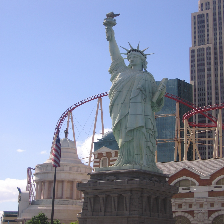

In [112]:
i = cv2.imread('./jpg/149900.jpg')
i = cv2.resize(i,(224,224))
cv2_imshow(i)


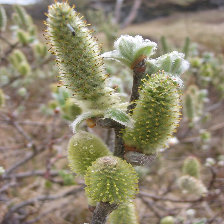

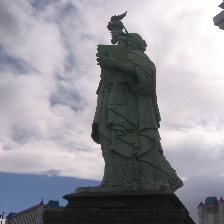

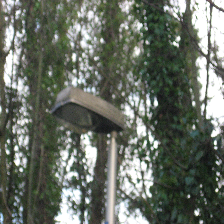

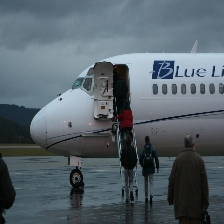

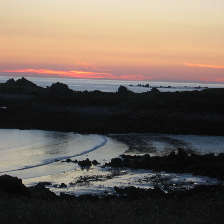

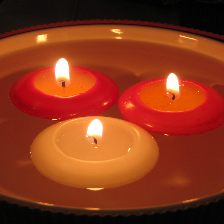

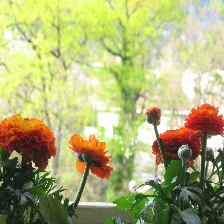

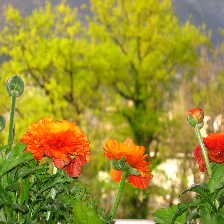

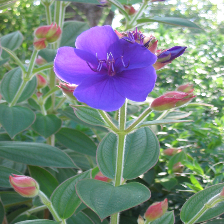

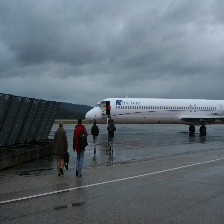

In [113]:
results('149900','classic')